In [1]:
%matplotlib inline
import make_discrete_vdf as mdv
import numpy as np
import matplotlib.pyplot as plt
from fancy_plot import fancy_plot
from multiprocessing import Pool
import time
from scipy.optimize import curve_fit
import multi_fc_functions as mff
from scipy.interpolate import RectBivariateSpline
import geo_dist as gd



In [2]:
#set up plasma parameters
#                    Vx  ,  Vy,  Vz ,Wper,Wpar, Np
#pls_par = np.array([-380., -30., 30., 20., 40., 5.]) 
pls_par = np.array([-580., 10., -10., 20., 30., 15.]) 
#pls_par = np.array([-480., -100., -80., 20., 50., 25.])
#pls_par = np.array([-380., -100., 50., 30., 10., 50.]) 
#pls_par = np.array([-880., 100.,-150., 30., 10., 5.]) 
#mag_par = np.array([np.cos(np.radians(75.))*np.cos(.1), np.sin(np.radians(75.))*np.cos(.1), np.sin(.1)]) 
mag_par = np.array([-np.cos(np.radians(25.)),np.sin(np.radians(25.)), 0.]) 
#mag_par = np.array([-1.,0., 0.])


In [3]:
#Changed to mean km/s in p,q space 2018/10/19
samp = 1.5e1
#make a discrete VDF
#updated clip to a velocity width 2018/10/12 J. Prchlik
#Set to a "Total velocity width" which could be measured by the space craft 2018/10/15
vel_clip = 8.*np.sqrt(np.sum(pls_par[4:6]**2))
dis_vdf = mdv.make_discrete_vdf(pls_par,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
normval = np.ones(dis_vdf['pgrid'].shape)
normval /= np.sum(normval)

#Add a positive Gaussian Kernal to "Measured" VDF
dis_vdf['vdf'] += 0.5*dis_vdf['vdf'].max()*np.exp(- ((dis_vdf['pgrid']-(20))/15)**2. - ((dis_vdf['qgrid']-(40))/15)**2.)
#update the interpolator function
dis_vdf['vdf_func'] =  RectBivariateSpline(dis_vdf['pgrid'][:,0],dis_vdf['qgrid'][0,:],dis_vdf['vdf'])
                         



In [4]:
#get random angles of faraday cup in phi and theta
#number of fc cups
ncup = 20


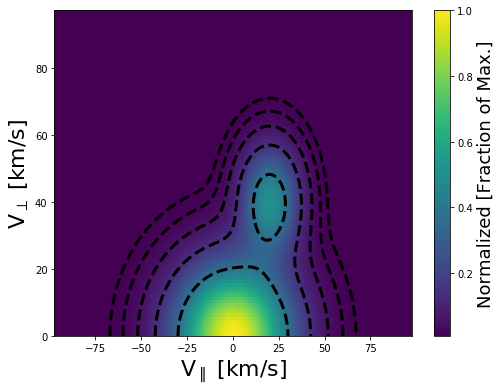

In [5]:
#"REAL" OBSERVATION
mdv.plot_vdf(dis_vdf)
plt.show()

In [6]:
reload(mff)
fcs,big_arr = mff.create_multi_fc(dis_vdf,ncup)

multi_fc_functions.py:653: RuntimeWarning: invalid value encountered in sqrt
  du = np.sqrt(pcov[1,1])
multi_fc_functions.py:654: RuntimeWarning: invalid value encountered in sqrt
  dw = np.sqrt(pcov[2,2])


In [7]:
#get speed solution per observatory
v_angl = big_arr[:,0]
uv_angl = big_arr[:,5]
#thermal speed in GSE
w_angl = big_arr[:,1]
uw_angl = big_arr[:,6]
#get the density to compute the magnitude
n_angl = big_arr[:,2]
un_angl = big_arr[:,7]


#get angles from big_arr
phis   = np.radians(big_arr[:,3])
thetas = np.radians(big_arr[:,4])

#Number of processors to use when parallel processing
nproc = 8




In [8]:
#Use values with density greater than .1 and an uncertainty less than 10% 
top5 = ((un_angl/n_angl < 4.50) & (n_angl > 1e-1)) #np.sort(n_angl)[-6]
print(un_angl/n_angl)


#get v_gse solution (Produces the same solution as the Wind spacecraft solution)
#in /crater/observatories/wind/code/dvapbimax/sub_bimax_moments.pro
v_vec =  mdv.compute_gse_from_fit(phis[top5],thetas[top5],-v_angl[top5]) #np.dot(np.dot(np.dot(v_svdc.T,wp_svdc),u_svdc.T),v_angl)
vx,vy,vz = v_vec


[  4.58566221e-03   3.04670256e-01              nan   2.38849357e+00
   2.58017321e+00   3.47858015e+00              nan   2.93894938e+00
   5.52296372e-01              nan   1.75186787e-01   1.03291794e-02
   3.13512941e-02   9.29464709e-05   2.86025799e+00   1.14474245e+00
   2.14482922e+01              nan   2.15923978e+01   2.44580305e-02]


/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [9]:
#Get Wper and Wpar vectors using maximum and minimum values
wv_par =  mdv.compute_gse_from_fit(np.radians(phis[top5]),np.radians(thetas[top5]),w_angl[top5])
wa = np.max(w_angl[top5])
we = np.min(w_angl[top5])



In [10]:
#compute angle between FC and the observed bulk velocity (cos(theta`))
n = np.median(np.abs(n_angl[top5]))

In [11]:
#dont let initial guess be smaller than half a bin size
#if we < min(dv)/2.:
#    we = min(dv)/2.
#
if we < 0.9*np.min(w_angl[top5]):
    we = np.min(w_angl[top5])
elif we > 1.1*np.max(w_angl[top5]):
    we = np.max(w_angl[top5])

if wa < 0.9*np.min(w_angl[top5]):
    wa = np.min(w_angl[top5])
elif wa > 1.1*np.max(w_angl[top5]):
    wa = np.max(w_angl[top5])

#make a discrete VDF with the incorrect parameters but the same grid
pls_par_bad = np.array([vx, vy, vz,we,wa,n])




In [12]:
#######Give info on best fit versus real solution######
print(pls_par)
print(pls_par_bad)

[-580.   10.  -10.   20.   30.   15.]
[-597.09029028   24.03357901  -20.48689538   17.01993862   38.94009881
   28.08442992]


In [13]:

######################################################################
######################################################################
#EVERYTHING BEFORE THIS WOULD BE MEASURED BY A SPACECRAFT
######################################################################
######################################################################

#Updated with vel_clip parameter 2108/10/12 J. Prchlik
dis_vdf_bad = mdv.make_discrete_vdf(pls_par_bad,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
#store the initial bad guess 
dis_vdf_bad_guess = dis_vdf_bad
dis_vdf_bad = dis_vdf_bad_guess

In [14]:
#Get the initial distribution based on input parameters 2018/09/19 J. Prchlik 
for k,i in enumerate(fcs.keys()):
    i = 'fc_{0:1d}'.format(k)
    #updated using dynamic sampling 2018/10/12 J. Prchlik
    fcs[i]['init_guess'] = mdv.arb_p_response(fcs[i]['x_meas'],dis_vdf_bad_guess,samp)






In [15]:
#Updated MC guess based on poor judgement of perpendicular velocity component
pgrid = np.abs(dis_vdf_bad_guess['pgrid'].ravel())
qgrid = np.abs(dis_vdf_bad_guess['qgrid'].ravel())

dis = np.zeros(pgrid.size)
for i,(x,y) in enumerate(zip(pgrid,qgrid)):
    dis[i] = gd.distance_point_ellipse(wa,we,x,y)
    
dist = dis.reshape(dis_vdf_bad_guess['pgrid'].shape)

1.27692381932e-34


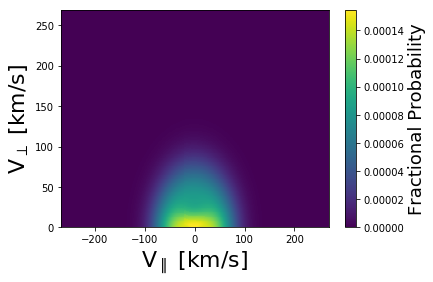

In [16]:
#Guess width
g_wid = 40 #km/s

#Initial guess around current guess of 2d VDF
pred_grid = dis_vdf_bad_guess['vdf'].copy()
good_vdf_values =  np.isfinite(pred_grid)
pred_grid[good_vdf_values == False] = np.min(pred_grid[good_vdf_values])
pred_grid -= np.min(pred_grid)
pred_grid /= np.sum(pred_grid)

#maximum value in VDF guess solution
max_pred_grid_norm = np.max(pred_grid)

#Initial guess based on ellipse near the kinematic values of the solar wind 
pred_grid += 0.5*max_pred_grid_norm*np.exp(- (dist/g_wid)**2.)


#Add a second component near 90 km/s
#pred_grid += 0.5*max_pred_grid_norm*np.exp(- ((dis_vdf['pgrid']-(-50))/g_wid)**2.)

#Also add a band at a radius of 90 km/s
pred_grid += 0.5*max_pred_grid_norm*np.exp(- ((np.sqrt((dis_vdf['pgrid']**2+dis_vdf['qgrid']**2))-(50))/g_wid)**2.)

#get normalization factor
pred_grid /= np.sum(pred_grid)


print(np.min(pred_grid))
#default prediction grid to set back to if the function gets stuck
default_grid = pred_grid.copy()

fig, ax = plt.subplots()

plotc = ax.pcolormesh(dis_vdf_bad_guess['pgrid'],dis_vdf_bad_guess['qgrid'],pred_grid)
cbar = fig.colorbar(plotc)

cbar.set_label('Fractional Probability',fontsize=18)
ax.set_xlabel(r'V$_\parallel$ [km/s]',fontsize=22)
ax.set_ylabel(r'V$_\perp$ [km/s]',fontsize=22)
plt.show()

In [17]:
#Probability of selecting a gaussian that subtracts or adds to the vdf
n_p_prob = np.array([0.5,0.5])

#Inital bad sum squared error value
tot_err = 1e31 #a very large number
per_err = .10

#whether a given p, q value improved the fit
improved = False
ip,iq = 0.,0.



#counter tells the number of iterations to go before resetting the initial guess PDF
counter = 0
#Number of iterations before resetting
tol_cnt = 100
#kernel size for fitting
kernel = 20.*np.sqrt(2.)

In [27]:
#Loop until completion
reload(mff)
iters = 9000
looper = True

start_loop = time.time()
fcs,dis_vdf_bad,pred_grid,kernel,improved,ip,iq,n_p_prob,counter,per_err_list,ker_sze_list = mff.mc_reconstruct(fcs,nproc,dis_vdf_bad,
                                                                             pred_grid,kernel,iters,verbose=False,
                                                                             default_grid=default_grid,counter=0,
                                                                             return_convergence=True)

end_loop = time.time()
print('Loop time {0:1.1f}s'.format(end_loop-start_loop))

Loop time 26203.7s


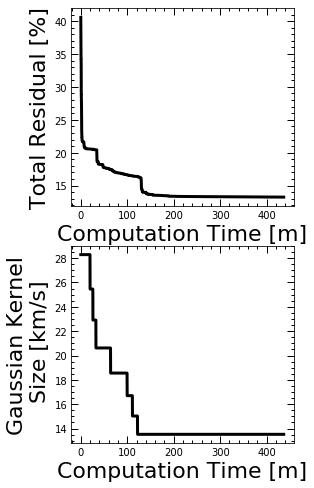

In [28]:
fig, ax = plt.subplots(nrows=2,figsize=(4,8))
xval = np.arange(len(per_err_list))*(end_loop-start_loop)/float(len(per_err_list))/60. # minutes


#plot the squared residual over time
ax[0].plot(xval,per_err_list,'-',color='black',linewidth=3)
ax[0].set_xlabel('Computation Time [m]',fontsize=22)
ax[0].set_ylabel('Total Residual [%]',fontsize=22)

#plot the kernel size over time
ax[1].plot(xval,ker_sze_list,'-',color='black',linewidth=3)
ax[1].set_xlabel('Computation Time [m]',fontsize=22)
ax[1].set_ylabel('Gaussian Kernel\n Size [km/s]',fontsize=22)
for iax in ax.ravel():
    fancy_plot(iax)

fig.savefig('mc_fit_residuals_over_time_ring_kernel_5.png',bbox_pad=0.1,bbox_inches='tight')
fig.savefig('mc_fit_residuals_over_time_ring_kernel_5.eps',bbox_pad=0.1,bbox_inches='tight')

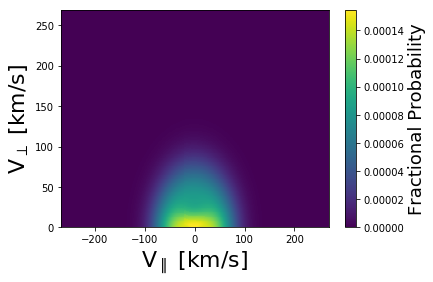

In [29]:
#Show prediction grid 
fig, ax = plt.subplots()

plotc = ax.pcolormesh(dis_vdf_bad_guess['pgrid'],dis_vdf_bad_guess['qgrid'],pred_grid)
cbar = fig.colorbar(plotc)

cbar.set_label('Fractional Probability',fontsize=18)
ax.set_xlabel(r'V$_\parallel$ [km/s]',fontsize=22)
ax.set_ylabel(r'V$_\perp$ [km/s]',fontsize=22)
plt.show()

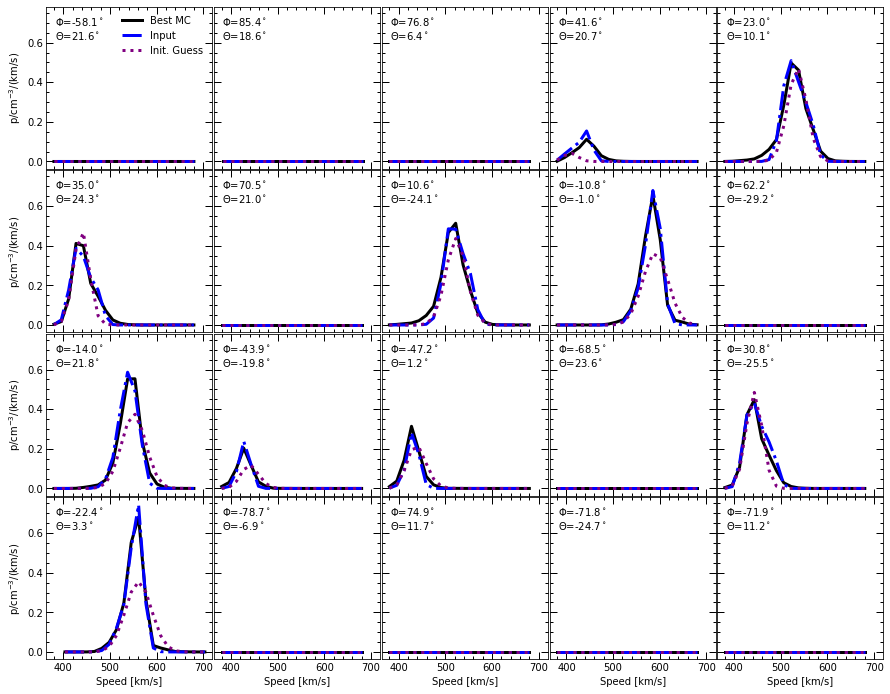

In [30]:
#Grid of FC guesses
mff.create_fc_grid_plot(fcs)
plt.show()

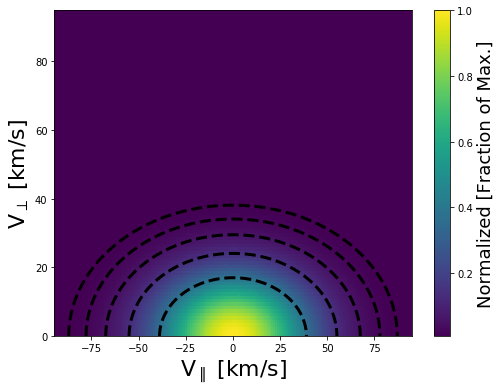

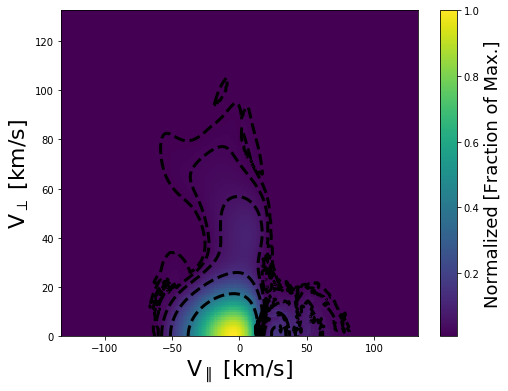

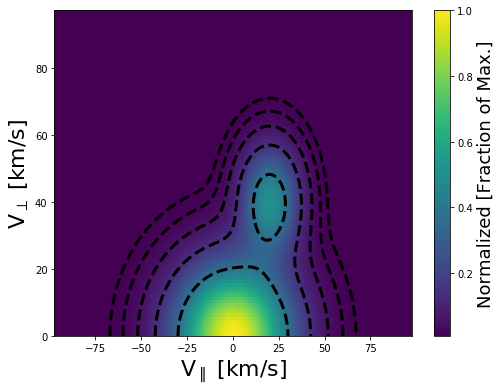

In [31]:
#Initial Guess from measurements
reload(mdv)
mdv.plot_vdf(dis_vdf_bad_guess)

#Best Fit MC VDF
mdv.plot_vdf(dis_vdf_bad)

#"REAL" OBSERVATION
mdv.plot_vdf(dis_vdf)

#difference between real and predicted observations
#how_bad = np.sum((dis_vdf_bad['vdf']-dis_vdf['vdf'])**2)/np.sum(dis_vdf['vdf']**2)
#print(how_bad)

plt.show()

In [24]:
print(ker_sze_list)

[28.284271247461902, 28.284271247461902, 28.284271247461902, 28.284271247461902, 28.284271247461902, 28.284271247461902, 28.284271247461902, 28.284271247461902, 28.284271247461902]
